In [ ]:
reset -fs

In [37]:
import collections
import math
import os
from pprint import pprint
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE

%matplotlib inline 

In [38]:
filename = '../github/DSCI6004-student/corpora/Archive.zip'

In [39]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Dataset size: {:,} words'.format(len(words)))

Dataset size: 118,158 words


In [40]:
words[:5]

['titl', 'a', 'winter', 'pilgrimag', 'author']

In [41]:
words[-5:]

['it', 'wa', 'undertaken', 'and', 'accomplish']

In [42]:
len(reverse_dictionary)

8500

In [43]:
vocabulary_size = 8500

def build_dataset(words):
    """ Replace rare words with UNK token which stands for "unknown".
    It is called a dustbin category, aka sweep the small count items into a single group.
    """
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [44]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Reduce memory by getting rid of the "heavy" list of strings

In [45]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [46]:
batch, labels = generate_batch(batch_size=8, 
                               num_skips=2, 
                               skip_window=1)

In [47]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [48]:
# TensorFlow setup
graph = tf.Graph()

with graph.as_default():

    # Input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

In [49]:
num_steps = 100000 #100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to '%s':" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  217.532073975
Nearest to 'that': corrod, manufactur, plung, grey, mansion, dispos, nightgar, moat,
Nearest to 'time': herd, lest, miscellan, accordingli, handrail, remot, marbl, strove,
Nearest to 'we': furious, peopl, ran, dusti, convent, anaesthet, governor, stork,
Nearest to 'after': simpli, irksomeand, henc, ploughland, stunt, induc, banner, vigor,
Nearest to 'and': orang, lloyd, sore, historian, xx, expert, blii, reproof,
Nearest to 'mai': sylvia, calvaryth, prosper, saewulf, gratuit, savageri, embalm, clap,
Nearest to 'or': power, vexati, came, pergamo, fortyon, souvent, familiar, min,
Nearest to 'if': thatcapernaum, distancealthough, safe, fur, carven, access, lifetimeaft, romanc,
Nearest to 'sai': museum, charm, symptom, pull, hospic, bush, perfunctori, similarli,
Nearest to 'these': mutter, quaint, transcrib, bust, shutter, longfallen, zerk, stamp,
Nearest to 'about': perchancehappi, neither, 1545, sat, boom, 600000, pole, blackskin,
Near

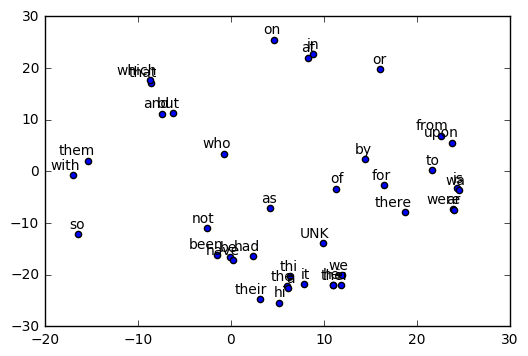

In [50]:
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

n_words_to_visualize = 40

for i, label in enumerate(labels[:n_words_to_visualize]):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [51]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

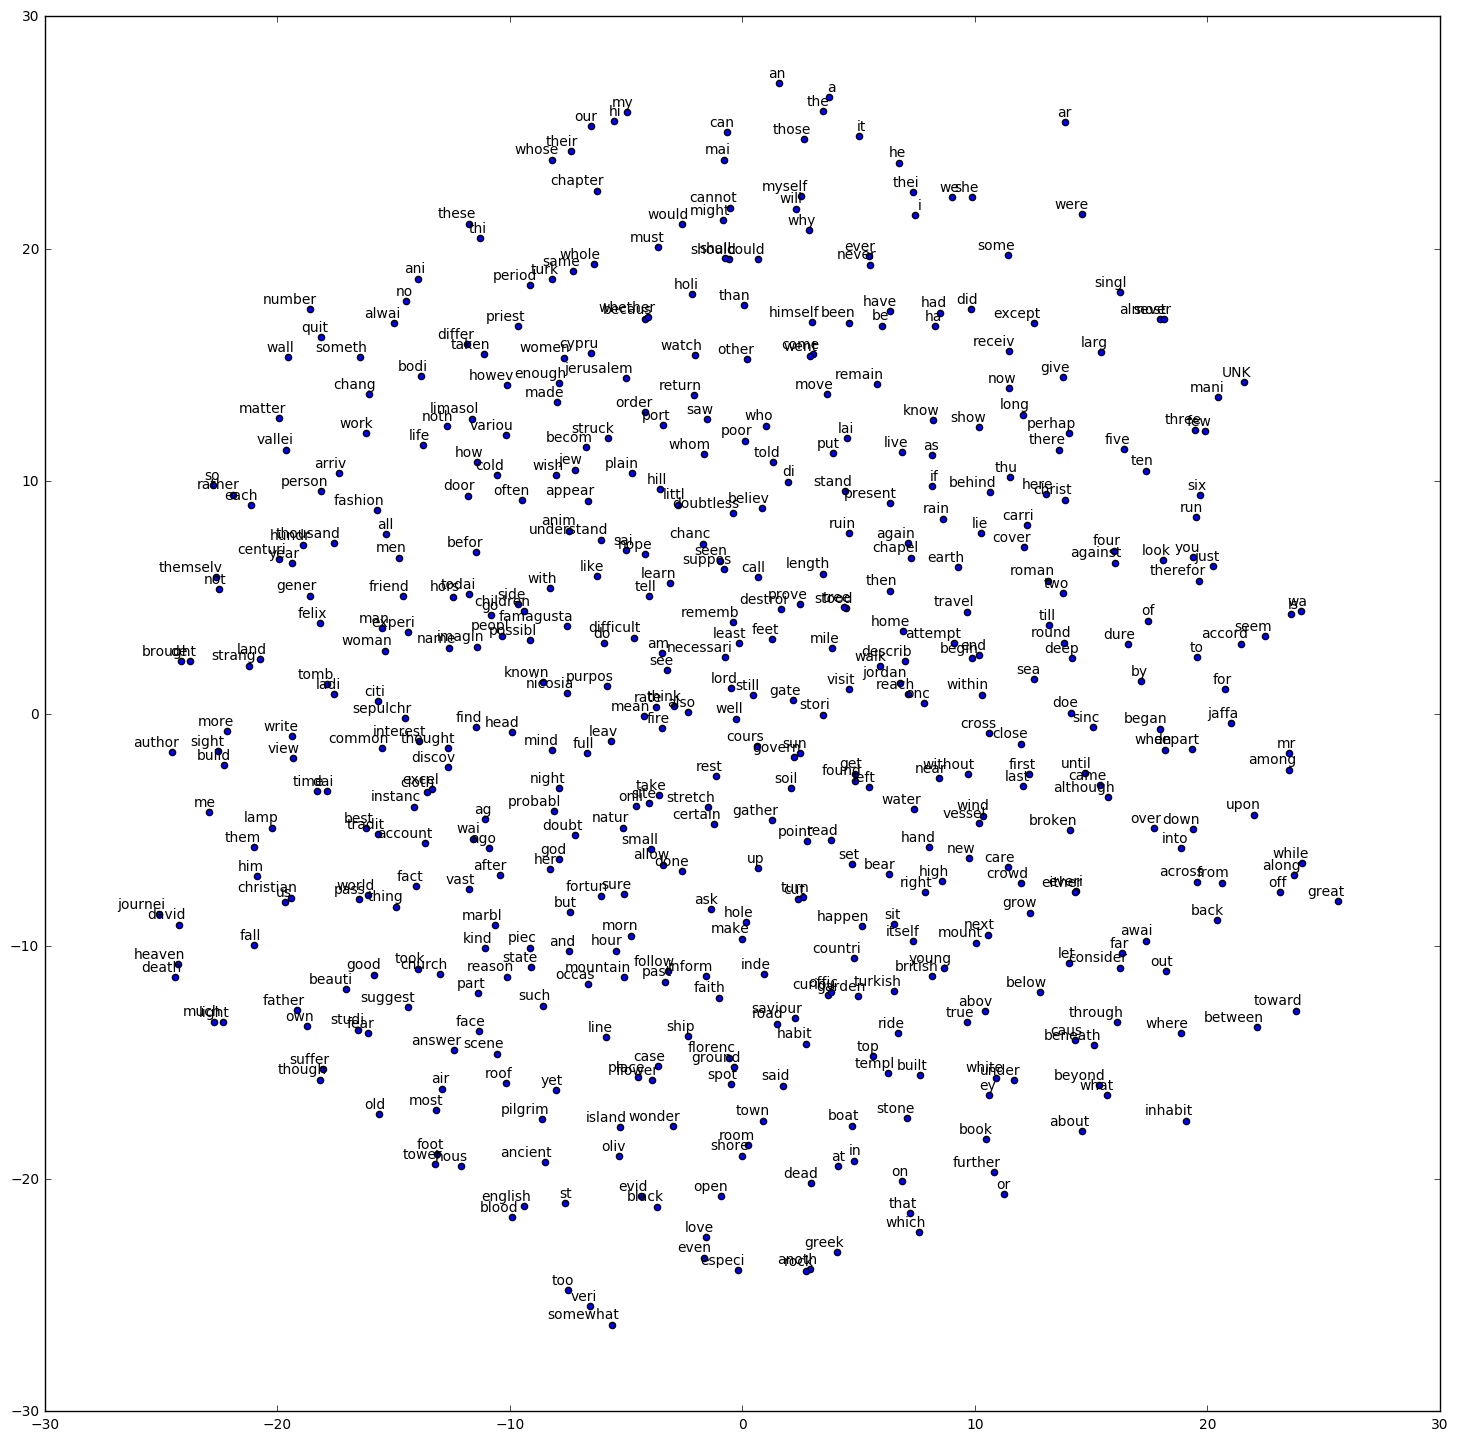

In [52]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)